In [1]:
%reload_ext autoreload
%matplotlib inline
%autoreload 2

!pip3 install --upgrade pip
!pip3 install --upgrade torch
!pip3 install torchvision
!pip3 install torchfusion
!pip3 install tensorboardx
!pip3 install pillow
!pip3 install pydicom
!pip3 install --upgrade keras
!pip3 install --upgrade keras.utils
!pip3 install opencv-python
!pip3 install nibabel

import os
import io
import errno
import scipy
import pydicom as dicom
import scipy.misc
import numpy as np
import tqdm
import random
import nibabel as nib
import datetime
from IPython.display import clear_output

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import tensorflow as tf
import tensorflow.contrib.slim as slim
from tensorflow import nn, layers
from tensorflow.contrib import layers as clayers 

import keras
import keras.backend as K
from keras.layers.core import Dropout, Lambda, Dense, Flatten
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.merge import Add, Concatenate
from keras.layers import concatenate
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Activation, Flatten, ZeroPadding2D, UpSampling2D, MaxPooling2D, merge, Convolution2D, Cropping2D
from keras.models import Model, load_model
from keras.optimizers import Adam, SGD
from keras.engine import InputSpec
from keras.engine.topology import Layer
from keras.utils import conv_utils
from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from keras import losses

import math

import torch
import torch.cuda as cuda
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader, random_split
from torch.distributions import Normal

import torchvision.utils as vutils
from torchvision import transforms, utils, datasets

from tensorboardX import SummaryWriter
from IPython import display

from PIL import Image

from getpass import getpass

from inspect import signature

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import average_precision_score
from sklearn import preprocessing

import warnings
warnings.filterwarnings(action = 'once')

Requirement already up-to-date: pip in /usr/local/lib/python3.6/site-packages (19.1.1)
  Using cached https://files.pythonhosted.org/packages/69/60/f685fb2cfb3088736bafbc9bdbb455327bdc8906b606da9c9a81bae1c81e/torch-1.1.0-cp36-cp36m-manylinux1_x86_64.whl
  Found existing installation: torch 1.0.1.post2
    Uninstalling torch-1.0.1.post2:
      Successfully uninstalled torch-1.0.1.post2
  Using cached https://files.pythonhosted.org/packages/59/60/23d2485a906961097c48f9e4a457dbb217ade35370600f00e02f7fdcec3a/torchfusion-0.3.6-py3-none-any.whl
     |████████████████████████████████| 1.4MB 4.5MB/s 
     |████████████████████████████████| 204kB 49.1MB/s 
  Stored in directory: /root/.cache/pip/wheels/ee/87/ce/a5023722374ca73b57fc8d4284ba6f973c01219b3c385a07e0
  Stored in directory: /root/.cache/pip/wheels/b1/c3/d6/9a1cc8f3a99a0fc1124cae20153f36af59a6e683daca0a0814
Successfully built visdom torchfile
Requirement already up-to-date: keras in /usr/local/lib/python3.6/site-packages (2.2.4)
  Stor

Using TensorFlow backend.


In [2]:
class Logger:

    def __init__(self, model_name, data_name):
        
        self.model_name = model_name
        self.data_name = data_name

        self.comment = '{}_{}'.format(model_name, data_name)
        self.data_subdir = '{}/{}'.format(model_name, data_name)

        self.writer = SummaryWriter(comment=self.comment)

    def log(self, loss, epoch, n_batch, num_batches):
        if isinstance(loss, torch.autograd.Variable):
            loss = loss.data.cpu().numpy()

        step = Logger._step(epoch, n_batch, num_batches)
        self.writer.add_scalar(self.comment + "/Loss", loss, step)
        
    def add_images(self, images, nrows, direc, step, normalize):      
        img_name = '{}/images{}'.format(self.comment, str(direc))

        horizontal_grid = vutils.make_grid(
            images, normalize=normalize, scale_each=True)

        self.writer.add_image(img_name, horizontal_grid, step)
        
    def log_images(self, full, segmented_gt, segmented_net, num_images, epoch, n_batch, num_batches, format='NCHW', normalize=True):
        if type(generated) == np.ndarray:
             full = torch.from_numpy(full)
            
        if type(real) == np.ndarray:
            segmented_gt = torch.from_numpy(segmented_gt)
            
        if type(sampled) == np.ndarray:
            segmented_net = torch.from_numpy(segmented_net)
            
        if format=='NHWC':
            full = full.transpose(1,3)
            segmented_gt = segmented_gt.transpose(1,3)
            segmented_net = segmented_net.transpose(1, 3)

        step = Logger._step(epoch, n_batch, num_batches)
        nrows = int(np.sqrt(num_images))

        self.add_images(full, nrows, '/full', step, normalize)
        self.add_images(segmented_gt, nrows, '/segmented_gt', step, normalize)
        self.add_images(segmented_net, nrows, '/segmented_net', step, normalize)

    def _save_images(self, fig, epoch, n_batch, comment=''):
        out_dir = './data/images/{}'.format(self.data_subdir)
        Logger._make_dir(out_dir)
        fig.savefig('{}/{}_epoch_{}_batch_{}.png'.format(out_dir, comment, epoch, n_batch))

    def save_models(self, net, epoch):
        out_dir = './data/models/{}'.format(self.data_subdir)
        Logger._make_dir(out_dir)
        torch.save(net.state_dict(), '{}/net_epoch_{}'.format(out_dir, epoch))

    def close(self):
        self.writer.close()

    @staticmethod
    def _step(epoch, n_batch, num_batches):
        return epoch * num_batches + n_batch

    @staticmethod
    def _make_dir(directory):
        try:
            os.makedirs(directory)
        except OSError as e:
            if e.errno != errno.EEXIST:
                raise

In [3]:
import warnings;
warnings.filterwarnings('ignore');

class MSDataset(Dataset): 
          
    def __init__(self, transforms=None):
        
        self.transforms = transforms
        
        direc = "/floyd/home"
        
        os.chdir(direc)
        user = getpass('BitBucket user')
        password = getpass('BitBucket password')
        os.environ['BITBUCKET_AUTH'] = user + ':' + password.replace("@", "%40")

        !git clone https://$BITBUCKET_AUTH@bitbucket.org/sidijju/msdata.git
        
        root = direc + "/msdata/"
        
        self.mri = []
        self.mask = []
        theta = (np.arange(-15, 15, 15) * np.pi) / 180.
        
        good_indices = []
        
        print("Started file processing")
        
        index = 0
        for filename in sorted(os.listdir(root)):
            print(filename)
            if "FLAIR" in filename:
                img = nib.load(root + filename)
                dat = img.get_data()
                dat = np.rollaxis(dat, 1)
                for image in dat:
                    image = image.astype(float)
                    image = np.expand_dims(preprocessing.normalize(image), axis = -1)
                    image = image[:, 150:480, :]
                    self.mri.append(image)
                    
            if "mask" in filename:
                img = nib.load(root + filename)
                dat = img.get_data()
                dat = np.rollaxis(dat, 1)
                for image in dat:
                    image = image.astype(float)
                    image = np.expand_dims(image, axis = -1)
                    image = image[:, 150:480, :]
                    if not (np.amax(image) == 0.0):
                        good_indices.append(index)
                    self.mask.append(image)
                    index += 1
        
        print("Completed file processing")
        '''
        self.mri_final = []
        self.mask_final = []
        
        
        for j in range(1):
            for i in good_indices:
                self.mri_final.append(self.mri[i])
                self.mask_final.append(self.mask[i])
        '''
        self.mri = np.dstack(self.mri)
        self.mask = np.dstack(self.mask)
        
        self.data = np.stack((self.mri, self.mask), axis=3)
        
        self.data = np.moveaxis(self.data, 0, 2)
        self.data = np.moveaxis(self.data, 0, 1)
        
        print("Completed")
        
        print(self.data.shape)

    def __getitem__(self, index):
        return self.data[index]
        
    def __len__(self):
        return len(self.data)
      

In [4]:
r_dim = 330 #512
c_dim = 192

image_shape = (r_dim, c_dim, 1)

In [5]:
dataset = MSDataset()

BitBucket user 
BitBucket password 


fatal: destination path 'msdata' already exists and is not an empty directory.
Started file processing
.git
patient26_FLAIR.nii.gz
patient26_mask.nii.gz
patient27_FLAIR.nii.gz
patient27_mask.nii.gz
patient28_FLAIR.nii.gz
patient28_mask.nii.gz
patient29_FLAIR.nii.gz
patient29_mask.nii.gz
patient30_FLAIR.nii.gz
patient30_mask.nii.gz
Completed file processing
Completed
(2560, 330, 192, 2)


In [6]:
#x_train, x_test, y_train, y_test = train_test_split(dataset.data[:, :, :, 0], dataset.data[:, :, :, 1], test_size=0.20)
from sklearn.utils import shuffle
def get_data(start, end):
    x = dataset.data[start:end , :, :, 0]
    y = dataset.data[start:end , :, :, 1]
    x, y = shuffle(x, y)
    x, y = np.expand_dims(x, axis = -1), np.expand_dims(y, axis = -1)
    return x, y

size = dataset.data.shape[0]
x_train, y_train = get_data(0, int(size*.6))
x_val, y_val = get_data(int(size*.6), int(size*.8))
x_test, y_test = get_data(int(size*.8), int(size))


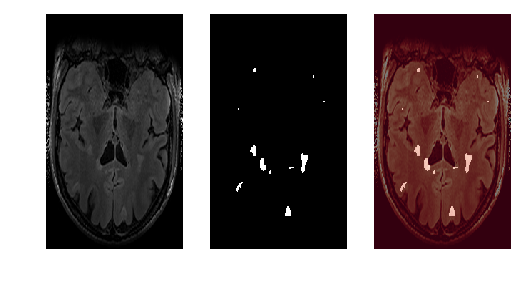

In [7]:
index = 20
fig = plt.figure(dpi = 100)
plt.tight_layout()

fig.add_subplot(1, 3, 1)
plt.axis('off')
a = x_train[index, :, :, 0]
plt.imshow(a, cmap = 'gray')

fig.add_subplot(1, 3, 2)
plt.axis('off')
b = y_train[index, :, :, 0]
plt.imshow(b, cmap = 'gray')

fig.add_subplot(1, 3, 3)
plt.axis('off')
plt.imshow(b, cmap = 'gray', interpolation= 'none')
plt.imshow(a, cmap='RdGy', alpha=0.5, interpolation = 'none')

plt.show()

## UNet

In [8]:
kinit = 'glorot_normal'

def UNet(): 
    
    K.set_image_dim_ordering('tf')
    
    concat_axis = -1

    inputs = Input(shape=image_shape)
                          
    conv1 = Conv2D(64, 5, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 5, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    b1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(b1)
    conv2 = Conv2D(96, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(96, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    b2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(b2)
    conv3 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    b3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(b3)
    conv4 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv44= Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    b4 = BatchNormalization()(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(b4)

    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)

    up_conv5 = UpSampling2D(size=(2, 2))(conv5)
    ch, cw = get_crop_shape(conv4, up_conv5)
    crop_conv4 = Cropping2D(cropping=(ch,cw))(conv4)
    up6 = concatenate([up_conv5, crop_conv4], axis=concat_axis)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)
    b6 = BatchNormalization()(conv6)

    up_conv6 = UpSampling2D(size=(2, 2))(b6)
    ch, cw = get_crop_shape(conv3, up_conv6)
    crop_conv3 = Cropping2D(cropping=(ch,cw))(conv3)
    up7 = concatenate([up_conv6, crop_conv3], axis=concat_axis) 
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)
    b7 = BatchNormalization()(conv7)

    up_conv7 = UpSampling2D(size=(2, 2))(b7)
    ch, cw = get_crop_shape(conv2, up_conv7)
    crop_conv2 = Cropping2D(cropping=(ch,cw))(conv2)
    up8 = concatenate([up_conv7, crop_conv2], axis=concat_axis)
    conv8 = Conv2D(96, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(96, (3, 3), activation='relu', padding='same')(conv8)
    b8 = BatchNormalization()(conv8)

    up_conv8 = UpSampling2D(size=(2, 2))(b8)
    ch, cw = get_crop_shape(conv1, up_conv8)
    crop_conv1 = Cropping2D(cropping=(ch,cw))(conv1)
    up9 = concatenate([up_conv8, crop_conv1], axis=concat_axis)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv9)
    b9 = BatchNormalization()(conv9)

    ch, cw = get_crop_shape(inputs, b9)
    conv9 = ZeroPadding2D(padding=((ch[0], ch[1]), (cw[0], cw[1])))(conv9)
    conv10 = Conv2D(1, (1, 1), activation = 'sigmoid')(conv9)

    model = Model(input = inputs, output = conv10)

    return model

def get_crop_shape(target, refer):
        # width, the 3rd dimension
        cw = (target.get_shape()[2] - refer.get_shape()[2]).value
        assert (cw >= 0)
        if cw % 2 != 0:
            cw1, cw2 = int(cw/2), int(cw/2) + 1
        else:
            cw1, cw2 = int(cw/2), int(cw/2)
        # height, the 2nd dimension
        ch = (target.get_shape()[1] - refer.get_shape()[1]).value
        assert (ch >= 0)
        if ch % 2 != 0:
            ch1, ch2 = int(ch/2), int(ch/2) + 1
        else:
            ch1, ch2 = int(ch/2), int(ch/2)

        return (ch1, ch2), (cw1, cw2)

## Training 

In [9]:
def save_all_weights(net, epoch_number, current_loss):
    now = datetime.datetime.now()
    os.chdir("/floyd/home/")
    save_dir = os.path.join("weights/", '{}_{}_{} run'.format(now.month, now.day, now.year))
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    net.save_weights(os.path.join(save_dir, 'epoch{}.h5'.format(epoch_number)), True)

def dice(y_true, y_pred):
    y_true_f = K.abs(K.flatten(y_true))
    y_pred_f = K.abs(K.flatten(y_pred))
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + K.epsilon()) / (K.sum(y_true_f) + K.sum(y_pred_f) + K.epsilon())

def dice_coef_loss(y_true, y_pred):
    return 1.-dice(y_true, y_pred)

def loss_func(y_true, y_pred):
    return dice_coef_loss(y_true, y_pred)

In [10]:
K.clear_session()
#net = load_model('latest_71619.h5', custom_objects={'loss_func': loss_func,'dice_coef_loss': dice_coef_loss, 'dice': dice})
net = UNet()
net.load_weights('latest_71619_weights.h5')
net.summary() 

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 330, 192, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 330, 192, 64) 1664        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 330, 192, 64) 102464      conv2d_1[0][0]                   
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 330, 192, 64) 256         conv2d_2[0][0]                   
_____________________________________

In [11]:
opt = SGD(lr=.001)

net.trainable = True
net.compile(optimizer=opt, loss=loss_func, metrics=[dice])

In [ ]:
num_epochs = 250

callbacks = [TensorBoard(log_dir='logs/' + str(datetime.datetime.now())),
             ModelCheckpoint(filepath='best_71719.h5', monitor='val_dice', save_best_only=True)
            ]

history = net.fit(x = x_train, 
                  y = y_train, 
                  batch_size=15, 
                  epochs = num_epochs, 
                  callbacks = callbacks, 
                  validation_data = (x_val, y_val), 
                  shuffle = True)

net.save('latest_71719.h5')

Train on 1536 samples, validate on 512 samples
Epoch 1/250
1536/1536 [==============================] - 28s 18ms/step - loss: 0.0698 - dice: 0.9302 - val_loss: 0.4828 - val_dice: 0.5172


In [ ]:
net.save_weights('latest_71719_weights.h5')

## Evaluation

In [ ]:
#net = load_model('latest_71619.h5', custom_objects={'loss_func': loss_func,  
#                                                  'dice': dice, 
#                                                  'dice_coef_loss': dice_coef_loss,})
#net.save_weights('best_71519_weights.h5')
net = UNet()
net.load_weights('latest_71719_weights.h5')
net.compile(optimizer=opt, loss=loss_func, metrics=[dice])
print('\n# Generating Predictions')
predictions = net.predict(x_test)
print('Predictions Shape', predictions.shape)


In [ ]:
print('\n# Evaluating on Test Dataset')
results = net.evaluate(x_test, y_test, batch_size=10)
print('Avg. Dice Coefficient on Test Dataset: ' + str(results[1]))

In [ ]:
def gen_sample(sample, thresh = 0.5):
    x = x_test[sample, :, :, 0]
    y = y_test[sample, :, :, 0]
    y_pred = predictions[sample, :, :, 0]

    fig = plt.figure(dpi = 300)
    fig.add_subplot(221)
    plt.axis('off')
    plt.imshow(y, cmap = 'gray', interpolation= 'none')
    plt.title('Ground Truth Mask', fontsize=6)

    fig.add_subplot(222)
    plt.axis('off')
    plt.imshow(y_pred, cmap = 'gray', interpolation= 'none')
    plt.title('Generated Mask', fontsize=6)

    fig.add_subplot(223)
    plt.tight_layout()
    plt.axis('off')
    plt.imshow(y, cmap = 'gray', interpolation= 'none')
    plt.title('Ground Truth Mask + Overlap', fontsize=6)
    plt.imshow(x, cmap='RdGy', alpha=0.5, interpolation = 'none')

    fig.add_subplot(224)
    plt.tight_layout()
    plt.axis('off')
    plt.imshow(np.where(y_pred > thresh, 1, 0), cmap = 'gray', interpolation= 'none')
    plt.title('Generated Mask + Overlap', fontsize=6)
    plt.imshow(x, cmap='RdGy', alpha=0.5, interpolation = 'none')
    plt.subplots_adjust(top = 0.92, right = 0.5)
    print('# Dice Coefficient: ' + str(K.eval(dice(K.cast(y, 'float32'), y_pred))))


In [ ]:
gen_sample(40)

In [ ]:
y_test_f = K.flatten(y_test)
y_pred_f = K.flatten(predictions)

precision, recall, _ = precision_recall_curve(K.eval(y_test_f), K.eval(y_pred_f))

average_precision = average_precision_score(K.eval(y_test_f), K.eval(y_pred_f))

step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))
plt.show()

In [ ]:
from sklearn.metrics import roc_curve, auc
result = roc_curve(K.eval(y_test_f), K.eval(y_pred_f))
fpr = result[0]
tpr = result[1]
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
# Compute confusion matrix
def cm(thresh = 0.5):
    cm = confusion_matrix(K.eval(y_test_f), np.where(K.eval(y_pred_f) > thresh, 1, 0))
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    classes = ["No Lesion", "Lesion"]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap="Blues")
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title='Confusion Matrix for Pixel Predictions',
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.3f' 
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()

In [ ]:
cm(0)

In [ ]:
cm()